In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive') # for google colab. adjust accordingly

Mounted at /content/MyDrive


In [ ]:
PARENT_DIR = '/content/MyDrive/MyDrive/Jennas_Code/' # for google colab. adjust accordingly

In [ ]:
# utilities you will need or are free to use
import pickle
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset

from torchtext.data.metrics import bleu_score

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tokenizer = nltk.RegexpTokenizer(r"\w+")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


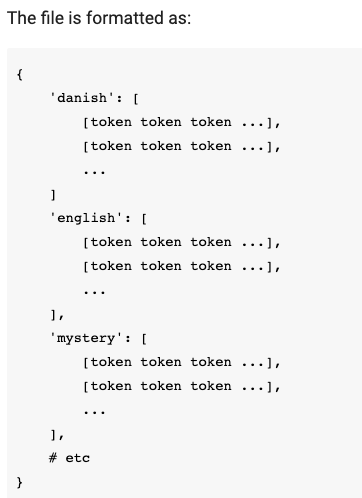

# Download data

In [ ]:
from torchtext.datasets import IWSLT2017
train_iter, valid_iter, test_iter = IWSLT2017(root='.data', split=('train', 'valid', 'test'), language_pair=('de', 'en'))

In [ ]:
src_sentence, tgt_sentence = next(train_iter) #just an example
print(src_sentence,tgt_sentence)
src_sentence, tgt_sentence = next(valid_iter) #just an example
print(src_sentence,tgt_sentence)
src_sentence, tgt_sentence = next(test_iter) #just an example
print(src_sentence,tgt_sentence)

Vielen Dank, Chris.
 Thank you so much, Chris.

Letztes Jahr habe ich diese beiden Folien gezeigt, um zu veranschaulichen, dass die arktische Eiskappe, die für annähernd drei Millionen Jahre die Grösse der unteren 48 Staaten hatte, um 40 Prozent geschrumpft ist.
 Last year I showed these two slides so that  demonstrate that the arctic ice cap,  which for most of the last three million years  has been the size of the lower 48 states,  has shrunk by 40 percent.

Vor einigen Jahren, hier bei TED, stellte Peter Skillman einen Design-Wettbewerb namens "Die Marshmallow-Herausforderung" vor.
 Several years ago here at TED, Peter Skillman  introduced a design challenge  called the marshmallow challenge.



In [ ]:
#####
# Train
#####

de = []
en = []
for t in train_iter:
  de.append(tokenizer.tokenize(t[0].lower()))
  en.append(tokenizer.tokenize(t[1].lower()))

In [ ]:
train_df = pd.DataFrame({'de':de,'en':en})
train_df

,de,en
0,"[es, ist, mir, wirklich, eine, ehre, zweimal, ...","[and, it, s, truly, a, great, honor, to, have,..."
1,"[ich, bin, wirklich, begeistert, von, dieser, ...","[i, have, been, blown, away, by, this, confere..."
2,"[das, meine, ich, ernst, teilweise, deshalb, w...","[and, i, say, that, sincerely, partly, because..."
3,"[versetzen, sie, sich, mal, in, meine, lage]","[put, yourselves, in, my, position]"
4,"[ich, bin, bin, acht, jahre, lang, mit, der, a...","[i, flew, on, air, force, two, for, eight, years]"
...,...,...
206106,"[den, alten, griechen, fiel, auch, nicht, eine...","[the, ancient, greeks, didn, t, just, wake, up..."
206107,"[wir, menschen, brauchten, jahrhunderte, um, s...","[it, took, centuries, even, for, humans, to, r..."
206108,"[deshalb, müssen, wir, unser, verständnis, von...","[and, so, we, must, continuously, challenge, o..."
206109,"[figuren, danke, danke, danke, danke, danke]","[characters, thank, you, thank, you, thank, yo..."


In [ ]:
# for record:
train_df.to_csv(PARENT_DIR+'data/iwlst_train.csv')

# make a dict
big_dict = {'de':train_df['de'].to_list(),
                  'en': train_df['en'].to_list()}
# save into pickle
file_name = PARENT_DIR+'data/iwlst_'+'train'+'_sentences.pkl'
dump(big_dict, open(file_name,'wb'))
print('Saved:',file_name)

In [ ]:
#####
# Valid
#####

de = []
en = []
for t in valid_iter:
  de.append(tokenizer.tokenize(t[0].lower()))
  en.append(tokenizer.tokenize(t[1].lower()))
valid_df = pd.DataFrame({'de':de,'en':en})
valid_df

# for record:
valid_df.to_csv(PARENT_DIR+'data/iwlst_valid.csv')

# make a dict
big_dict = {'de':valid_df['de'].to_list(),
                  'en': valid_df['en'].to_list()}
# save into pickle
file_name = PARENT_DIR+'data/iwlst_'+'valid'+'_sentences.pkl'
pickle.dump(big_dict, open(file_name,'wb'))
print('Saved:',file_name)

Saved: /content/MyDrive/MyDrive/Jennas_Code/data/iwlst_valid_sentences.pkl


In [ ]:
#####
# Test
#####

de = []
en = []
for t in test_iter:
  de.append(tokenizer.tokenize(t[0].lower()))
  en.append(tokenizer.tokenize(t[1].lower()))
test_df = pd.DataFrame({'de':de,'en':en})
test_df

# for record:
test_df.to_csv(PARENT_DIR+'data/iwlst_test.csv')

# make a dict
big_dict = {'de':test_df['de'].to_list(),
                  'en': test_df['en'].to_list()}
# save into pickle
file_name = PARENT_DIR+'data/iwlst_'+'test'+'_sentences.pkl'
dump(big_dict, open(file_name,'wb'))
print('Saved:',file_name)

# Take 10% of the dataset

In [ ]:
def get_small(t_iter,name):
  """
  t_iter: train_iter, test_iter,valid_iter
  t: 'train','test','valid'
  """
  de = []
  en = []
  for t in t_iter:
    de.append(tokenizer.tokenize(t[0].lower()))
    en.append(tokenizer.tokenize(t[1].lower()))
  t_df = pd.DataFrame({'de':de,'en':en})
  t_df = t_df.sample(frac=0.1, replace=False, random_state=1)
  print(len(t_df))
  # make a dict
  big_dict = {'de':t_df['de'].to_list(),
                    'en': t_df['en'].to_list()}
  # save into pickle
  print(PARENT_DIR)
  file_name = PARENT_DIR+'data/iwlst_'+ name +'_sentences_small.pkl'
  
  pickle.dump(big_dict, open(file_name,'wb'))
  print('Saved:',file_name)

get_small(train_iter,'train')
get_small(test_iter,'test')
get_small(valid_iter,'valid')

20611
/content/MyDrive/MyDrive/Jennas_Code/
Saved: /content/MyDrive/MyDrive/Jennas_Code/data/iwlst_train_sentences_small.pkl
157
/content/MyDrive/MyDrive/Jennas_Code/
Saved: /content/MyDrive/MyDrive/Jennas_Code/data/iwlst_test_sentences_small.pkl
89
/content/MyDrive/MyDrive/Jennas_Code/
Saved: /content/MyDrive/MyDrive/Jennas_Code/data/iwlst_valid_sentences_small.pkl


In [ ]:
# verify that they are of the desired length
# load pickled data and make datasets

with open(PARENT_DIR+"data/iwlst_train_sentences_small.pkl", "rb") as f: # Can edit based on need
    train_dict = pickle.load(f)
with open(PARENT_DIR+"data/iwlst_valid_sentences_small.pkl", "rb") as f:
    val_dict = pickle.load(f)
with open(PARENT_DIR+"data/iwlst_test_sentences_small.pkl", "rb") as f:
    test_dict = pickle.load(f)

print(len(train_dict['de']))
print(len(val_dict['de']))
print(len(test_dict['de']))

20611
89
157


In [ ]:
# check 
train_dict['de'][:2]

[['was', 'bedeutet', 'es', 'menü', 'auf', 'arabisch', 'zu', 'sagen'],
 ['aber',
  'mein',
  'kollege',
  'pieter',
  'abbeel',
  'der',
  'hier',
  'in',
  'berkeley',
  'ist',
  'hat',
  'ein',
  'neues',
  'set',
  'an',
  'techniken',
  'entwickelt',
  'um',
  'einen',
  'roboter',
  'anhand',
  'von',
  'beispielen',
  'zu',
  'unterrichten']]

In [ ]:
test_dict['en'][:2]

[['and',
  'what',
  'the',
  'marshmallow',
  'challenge',
  'does',
  'is',
  'it',
  'helps',
  'them',
  'identify',
  'the',
  'hidden',
  'assumptions'],
 ['you', 'can', 'jump', 'right', 'into', 'a', 'specific', 'issue']]

In [ ]:
########## Don't run this section above again: get 10% of everything ##############